In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


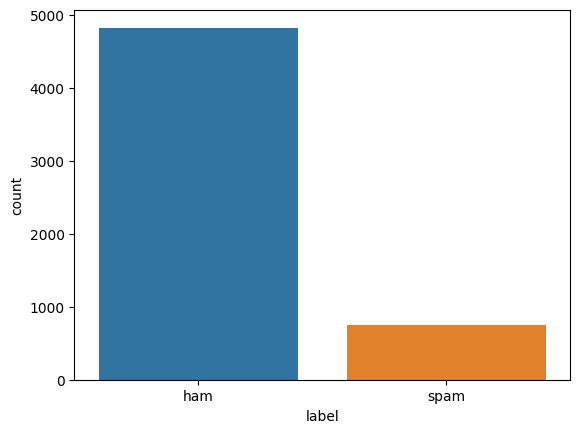

In [ ]:
sns.countplot(x=df['label'])
plt.show()


In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [ ]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
  total_words_length=len(s)
  print(total_words_length)


Streaming output truncated to the last 5000 lines.
3416
3416
3418
3422
3426
3427
3431
3442
3444
3444
3447
3451
3455
3456
3465
3470
3474
3475
3484
3494
3501
3503
3510
3510
3510
3513
3516
3519
3529
3529
3530
3532
3533
3538
3552
3554
3556
3559
3568
3576
3577
3590
3592
3602
3608
3610
3613
3619
3619
3621
3633
3635
3640
3644
3646
3649
3658
3663
3663
3664
3665
3670
3679
3680
3684
3688
3690
3691
3693
3700
3701
3703
3711
3717
3718
3721
3722
3727
3733
3737
3743
3744
3744
3747
3756
3756
3760
3764
3776
3778
3781
3785
3790
3795
3796
3797
3799
3800
3804
3808
3816
3821
3821
3824
3829
3833
3836
3840
3842
3843
3845
3856
3859
3859
3871
3882
3884
3888
3890
3900
3902
3905
3910
3912
3913
3917
3919
3921
3922
3922
3925
3930
3934
3937
3938
3940
3950
3950
3968
3973
3976
3980
3980
3981
3991
3996
3998
4007
4008
4010
4012
4014
4025
4030
4035
4037
4041
4042
4052
4055
4056
4061
4068
4068
4069
4080
4081
4088
4089
4092
4099
4100
4105
4107
4111
4117
4120
4123
4130
4132
4135
4136
4140
4141
4145
4152
4152
4157
4163
4169

In [ ]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [ ]:
#Model 1
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


In [ ]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [ ]:
history_1 = model_1.fit(X_train,y_train,epochs =5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 14s 87ms/step - loss: 0.6027 - accuracy: 0.9168 - val_loss: 0.5772 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 16s 113ms/step - loss: 0.5701 - accuracy: 0.9877 - val_loss: 0.5736 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 9s 63ms/step - loss: 0.5657 - accuracy: 0.9955 - val_loss: 0.5731 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 16s 113ms/step - loss: 0.5641 - accuracy: 0.9984 - val_loss: 0.5728 - val_accuracy: 0.9794
Epoch 5/5
140/140 [==============================] - 12s 86ms/step - loss: 0.5633 - accuracy: 0.9989 - val_loss: 0.5731 - val_accuracy: 0.9794


<Axes: >

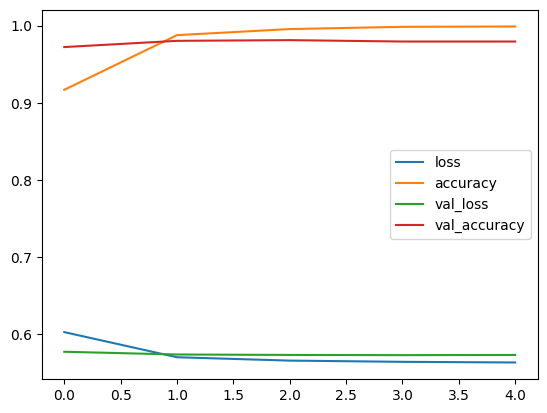

In [ ]:
pd.DataFrame(history_1.history).plot()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	'''
	fit the model with given epochs, train
	and test data
	'''
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict


In [ ]:
#Model 2
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 48s 258ms/step - loss: 0.0591 - accuracy: 0.9814 - val_loss: 0.0897 - val_accuracy: 0.9812
Epoch 2/5
140/140 [==============================] - 31s 224ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1036 - val_accuracy: 0.9749
Epoch 3/5
140/140 [==============================] - 35s 250ms/step - loss: 1.4898e-04 - accuracy: 1.0000 - val_loss: 0.1267 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 33s 235ms/step - loss: 2.4973e-05 - accuracy: 1.0000 - val_loss: 0.1337 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 30s 211ms/step - loss: 1.5036e-05 - accuracy: 1.0000 - val_loss: 0.1393 - val_accuracy: 0.9812


In [ ]:
#Model 3
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/5
140/140 [==============================] - 9s 42ms/step - loss: 0.3224 - accuracy: 0.9179 - val_loss: 0.1245 - val_accuracy: 0.9659
Epoch 2/5
140/140 [==============================] - 9s 61ms/step - loss: 0.0857 - accuracy: 0.9789 - val_loss: 0.0729 - val_accuracy: 0.9776
Epoch 3/5
140/140 [==============================] - 4s 32ms/step - loss: 0.0591 - accuracy: 0.9834 - val_loss: 0.0609 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 6s 44ms/step - loss: 0.0458 - accuracy: 0.9861 - val_loss: 0.0538 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0442 - accuracy: 0.9850 - val_loss: 0.0514 - val_accuracy: 0.9839


In [ ]:
compile_model(model_3)
history_3 = fit_model(model_3,epochs=5)

Epoch 1/5
140/140 [==============================] - 9s 42ms/step - loss: 0.0373 - accuracy: 0.9883 - val_loss: 0.0484 - val_accuracy: 0.9839
Epoch 2/5
140/140 [==============================] - 5s 37ms/step - loss: 0.0374 - accuracy: 0.9865 - val_loss: 0.0514 - val_accuracy: 0.9839
Epoch 3/5
140/140 [==============================] - 7s 53ms/step - loss: 0.0315 - accuracy: 0.9899 - val_loss: 0.0502 - val_accuracy: 0.9865
Epoch 4/5
140/140 [==============================] - 7s 53ms/step - loss: 0.0296 - accuracy: 0.9899 - val_loss: 0.0525 - val_accuracy: 0.9848
Epoch 5/5
140/140 [==============================] - 8s 55ms/step - loss: 0.0264 - accuracy: 0.9908 - val_loss: 0.0538 - val_accuracy: 0.9857


In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,
							'USE-Transfer learning Model':model_3_results}).transpose()

total_results


35/35 [==============================] - 3s 73ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.980269,0.963768,0.886667,0.923611
Bidirectional-LSTM Model,0.981166,0.951049,0.906667,0.928328
USE-Transfer learning Model,0.985650,0.971831,0.920000,0.945205


<Axes: >

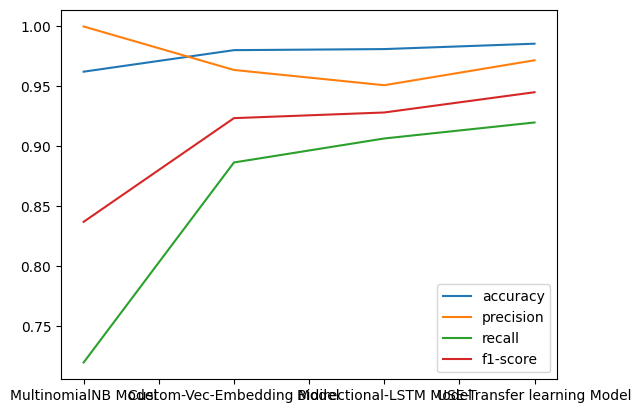

In [ ]:
total_results.plot()